In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams["font.size"] = "12"
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

# SET THIS PARAMETER FOR ALL SCRIPT
B_scale = 0.12


grid_coordinates = []
with open('../../../Grids/Pe_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../../Grids/Pe_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../../Grids/Pe_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

"""bott_indices = []
with open(f'Pe_Bott_indices_flux_{B_scale}.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)
"""
# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

## DEFINITION OF USEFUL FUNCTIONS

# We now change the Hamiltonian to be rotationally symmetric a thus we change the Peierls phase
# Calculation in notes
# Everything else is identical to the other rotation script
def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs, H

# Read the phases in
evec_phases = []
with open('../../../Separate_files/Pe_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

def time_evolve_evec(group_of_states, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [np.exp(1j*(eval[i]/hbar)*t)*evec[i] for i in group_of_states]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([(1/a)*x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states

# Check for any degeneracies in energy eigen functions

def check_degeneracy(eval, grain):
    deg_ener = []
    for count, ele in enumerate(eval):
        evals_list = list(eval)
        eles = [(z,index) for index, z in enumerate(eval) if abs(ele - z) < 10**(-grain) and evals_list.index(z) != count]
        if len(eles) > 0:
            deg_ener.append(count)
        else:
            pass
    if len(deg_ener) == 0:
        return print(f'No degeneracies were found with grain= 10**(-{grain})')
    else:
        print(f'Degeneracies were found with grain= 10**(-{grain})')
        return deg_ener
    


In [3]:
B_full = 2127.2827861030087
evals, evecs, H = Hamil_solve(grid_scaled, jump_scaled, (B_scale)*B_full)
deg_energies = check_degeneracy(evals, 5)

Degeneracies were found with grain= 10**(-5)


In [4]:
"""# Diagonalize Hamiltonian for different fluxes and plot the E/state number plots
# Define fluxes
Bs = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]

for b in Bs:
    eval, evec, H = Hamil_solve(grid_scaled, jump_scaled, (b)*B_full)
    fig, ax = plt.subplots(figsize= (8,6))

    xs = np.arange(0,len(evec))

    # First we plot all phases
    ax.scatter(xs,eval, facecolor= 'w', edgecolors= 'k', s= 8)

    ax.set_title(r'$\phi / \phi_0$ = {}'.format(b))
    ax.set_xlabel('State number')
    ax.set_ylabel('E', rotation= 0)
    plt.show()"""

"# Diagonalize Hamiltonian for different fluxes and plot the E/state number plots\n# Define fluxes\nBs = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]\n\nfor b in Bs:\n    eval, evec, H = Hamil_solve(grid_scaled, jump_scaled, (b)*B_full)\n    fig, ax = plt.subplots(figsize= (8,6))\n\n    xs = np.arange(0,len(evec))\n\n    # First we plot all phases\n    ax.scatter(xs,eval, facecolor= 'w', edgecolors= 'k', s= 8)\n\n    ax.set_title(r'$\\phi / \\phi_0$ = {}'.format(b))\n    ax.set_xlabel('State number')\n    ax.set_ylabel('E', rotation= 0)\n    plt.show()"

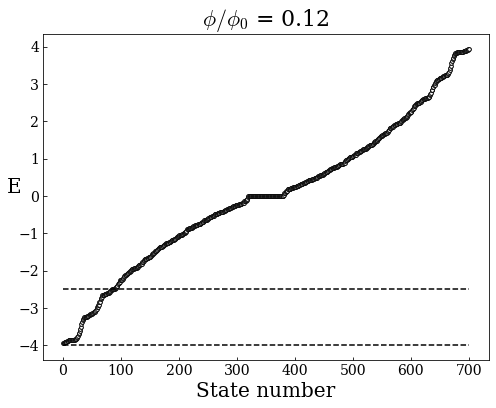

In [6]:
# Check different fluxes for edge states
eval_check, evec_check, H_check = Hamil_solve(grid_scaled, jump_scaled, (B_scale)*B_full)
fig, ax = plt.subplots(figsize= (8,6))

xs = np.arange(0,len(evec_check))

# First we plot all
ax.scatter(xs, eval_check, facecolor= 'w', edgecolors= 'k', s= 14)

"""# Now we highlight all with interesting Bott indices
# First select only bott indices
b_indices = [x[1] for x in bott_indices]
ys_ex = [evals[i] for i in b_indices]
ax.scatter(x= b_indices, y= ys_ex, color= 'r', label= 'Non-zero Bott')"""

cutoff_low = -4
cutoff_high = -2.5
ax.hlines(y= cutoff_low, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k')
ax.hlines(y= cutoff_high, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k', label= 'Cutoff')


#ax.legend()
ax.set_title(r'$\phi / \phi_0$ = {}'.format(B_scale))
ax.set_xlabel('State number')
ax.set_ylabel('E', rotation= 0)
plt.show()

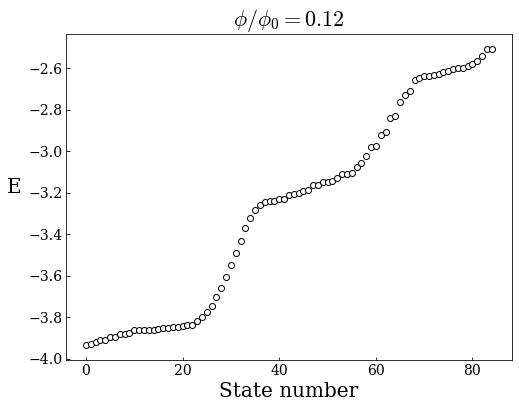

In [7]:
# Filter according to the above cutoff
filt_evals = [(ele, i) for i, ele in enumerate(eval_check) if cutoff_low <= ele and ele <= cutoff_high]

# Plot of E as a function of site number
fig, ax = plt.subplots(figsize= (8,6))

xs = [i for ele, i in filt_evals]
ys = [ele for ele, i in filt_evals]

# First we plot all phases
ax.scatter(x= xs, y= ys, facecolors= 'w', edgecolors= 'k', label= 'All')

"""# Now we highlight all with interesting Bott indices
# First select only bott indices
b_indices_filt_temp = [[x[1] for x in bott_indices if x[1] == z] for y, z in filt_evals]
b_indices_filt = [item for sublist in b_indices_filt_temp for item in sublist]
ys_ex = [evals[i] for i in b_indices_filt]
ax.scatter(x= b_indices_filt, y= ys_ex, color= 'r', label= 'Non-zero Bott')"""

cutoff_low2 = -0.8
cutoff_high2 = -0.49
#ax.hlines(y= cutoff_low2, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k')
#ax.hlines(y= cutoff_high2, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k', label= 'Cutoff 2')


#ax.legend()
ax.set_title('$\phi / \phi_0 = {}$'.format(B_scale))
ax.set_xlabel('State number')
ax.set_ylabel('E   ', rotation= 0)
plt.show()

In [17]:
"""second_filter_temp = [[(ele, i) for ele,i in filt_evals if cutoff_low2 <= ele and ele <= cutoff_high2 and i == k] for k in b_indices_filt]
second_filter = [item for sublist in second_filter_temp for item in sublist]"""

second_filter = [(ele, i) for ele,i in filt_evals if cutoff_low2 <= ele and ele <= cutoff_high2]

frames = range(len(second_filter))

for f, sf in zip(frames, second_filter):
    # Set figure up first
    fig, ax = plt.subplots(figsize=(6,6))

    # Plot all possible paths between vertices
    for i,j in zip(grid_scaled, jump_scaled):
        xs = [w[0] for w in j]
        ys = [w[1] for w in j]
        for l,k in zip(xs,ys):
            ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)

    # Get points for scatter plot
    xs = [w[0] for w in grid_scaled]
    ys = [w[1] for w in grid_scaled]

    dos = [(x.conj() * x).real for x in evec_check[sf[1]]]
    dos_max = max(dos)

    # Plotting part
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.colorbar(cf)
    plt.axis('equal')

    plt.set_cmap('hot_r')
    plt.savefig(f'prob_dens_flux_{B_scale}/flux_{B_scale}_state_{sf[1]}.png', bbox_inches= 'tight')
    plt.close()